In [1]:
# =============================================================================================
# [26 Mei 2020]:
# loss function diganti dengan menggunakan implemenentasi Large Margin Cosine (LMC) Loss 
# di repo YirongMao berikut: https://github.com/YirongMao/softmax_variants
#
# LMC Loss adalah loss function yang secara teori akan diimplementasikan sejak awal. Paper LMC
# Loss: https://arxiv.org/abs/1801.09414
# 
# Cosine Embedding Loss yang sempat digunakan ternyata tidak benar-benar sama matematikanya
# dengan LMC Loss, karena itu implementasinya diganti dengan implementasi dari YirongMao
# =============================================================================================

#Imporing libraries
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.autograd import Variable
%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

# ==============================================================================================================
# [26 Mei 2020]: ditambahkan agar angka random selalu sama ketika program dijalankan, sehingga hasil selalu sama
# ==============================================================================================================
np.random.seed(1234)
torch.manual_seed(1234)
# ==============================================================================================================

In [2]:
#Reading data
learn_data = pd.read_csv("bigml_59c28831336c6604c800002a.csv")
pd.options.display.max_columns = None
learn_data

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,415,414-4276,no,yes,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False
3329,WV,68,415,370-3271,no,no,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False
3330,RI,28,510,328-8230,no,no,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False
3331,CT,184,510,364-6381,yes,no,0,213.8,105,36.35,159.6,84,13.57,139.2,137,6.26,5.0,10,1.35,2,False


In [3]:
#Defining columns
numerical_columns = ['area code', 'number vmail messages', 'total day minutes', 'total day calls',
                     'total day charge', 'total eve minutes', 'total eve calls', 'total eve charge', 'total night minutes',
                     'total night calls', 'total night charge', 'total intl minutes', 'total intl calls',
                     'total intl charge', 'customer service calls']
categorical_columns = ['state', 'international plan', 'voice mail plan']
outputs = ['churn']

In [4]:
#Processing columns

#Numerical
numerical_data = np.stack([learn_data[col].values for col in numerical_columns], 1)
numerical_data = torch.tensor(numerical_data, dtype=torch.float)

#Categorical
for category in categorical_columns:
    learn_data[category] = learn_data[category].astype('category')
    
st = learn_data['state'].cat.codes.values
ip = learn_data['international plan'].cat.codes.values
vm = learn_data['voice mail plan'].cat.codes.values

categorical_data = np.stack([st, ip, vm], 1)
categorical_data = torch.tensor(categorical_data, dtype=torch.int64)

#Outputs
learn_data[outputs] = learn_data[outputs].astype(int)

outputs = torch.tensor(learn_data[outputs].values).flatten()
outputs = outputs.long()

In [5]:
#Dividing the data
total_records = 3333
train_records = int(total_records * .6)
valid_records = int(total_records * .2)
test_records = int(total_records * .2)
numerical_train_data = numerical_data[:train_records]
numerical_valid_data = numerical_data[train_records:train_records+valid_records]
numerical_test_data = numerical_data[train_records+valid_records:total_records]
categorical_train_data = categorical_data[:train_records]
categorical_valid_data = categorical_data[train_records:train_records+valid_records]
categorical_test_data = categorical_data[train_records+valid_records:total_records]
train_outputs = outputs[:train_records]
valid_outputs = outputs[train_records:train_records+valid_records]
test_outputs = outputs[train_records+valid_records:total_records]

In [6]:
from torch.nn.parameter import Parameter
from torch.nn import init
import math

#Creating the Neural Network
class Model(nn.Module):

    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(15, 100)
        self.act1 = nn.ReLU(inplace=True)
        
        # =============================================================================================
        # [26 Mei 2020]:
        # weights1 dan 2 tidak ada di model ini, karena sudah ada sebagai atribut self.centers di  
        # module LMC_Loss di model_utils.py.
        # =============================================================================================
        
        self.layer1_1 = nn.Embedding(51, 5)
        self.layer1_2 = nn.Embedding(2, 5)
        self.layer1_3 = nn.Embedding(2, 5)
        
    def forward(self, x_numerical, x_categorical):
        x1 = self.layer1(x_numerical)
        
        x1_embedding = self.layer1_1(x_categorical[:,0])
        x2_embedding = self.layer1_2(x_categorical[:,1])
        x3_embedding = self.layer1_3(x_categorical[:,2])
        x_embedding = torch.cat([x1_embedding,x2_embedding,x3_embedding], 1)
        
        x1_1 = torch.cat([x1, x_embedding], 1)
        
        x1_act = self.act1(x1_1)
        
        return x1_act

In [7]:
model = Model()

In [8]:
# =============================================================================================
# [26 Mei 2020]: 
# menambahkan loss baru dengan library LMCLoss dari YirongMao. Cross entropy loss tetap ada, 
# karena implementasi LMCLoss YirongMao masih memanfaatkan Cross Entropy Loss asli Pytorch.
# Cek cara implementasi di: https://github.com/YirongMao/softmax_variants/blob/master/train_mnist_LMCL.py
#
# margin (parameter m) menggunakan nilai 0.35, sesuai hasil penelitian dari paper asli LMCLoss
# yang menemukan bahwa nilai optimalnya di 0.35 atau 4.
# =============================================================================================

import model_utils

lmcl_loss = model_utils.LMCL_loss(num_classes=2, feat_dim=115, m=0.35)
optimizer_lmcl = torch.optim.Adam(lmcl_loss.parameters(), lr=0.001)

# =============================================================================================
# [26 Mei 2020]: 
# cross entropy loss ditambahkan parameter weight, karena ternyata data imbalance (data not churn
# jauh lebih banyak dari churn, dengan rasio sekitar 85:15). Data imbalance ini menyebabkan hasil 
# prediksi untuk kelas churn tidak baik. Solusinya adalah dengan menggunakan parameter weight di
# cross entropy loss, sehingga penalty untuk salah di kelas churn jauh lebih besar daripada salah
# di kelas not churn. Penalty diperbesar dengan rasio kebalikan dari rasio jumlah datanya (15:85)
# =============================================================================================
churn_percentage = 0.85
#Defining loss function
loss_function = nn.CrossEntropyLoss(weight=torch.Tensor([1-churn_percentage, churn_percentage]))
# loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
#Training the data
epochs = 100 #JUMLAH BERAPA KALI DATASET DIGUNAKAN UNTUK TRAIN MODEL
batch_size = 10
mean_losses_train = []
mean_losses_valid = []
best_loss_valid = np.inf

for i in range(epochs):
    aggregated_losses_train = []
    aggregated_losses_valid = []
    i += 1
    for j in range((train_records//batch_size)+1):
        start_train = j*batch_size
        end_train = start_train+10
        train = model(numerical_train_data[start_train:end_train], categorical_train_data[start_train:end_train]) # yg error 1
        logits, mlogits = lmcl_loss(train, train_outputs[start_train:end_train])
        train_loss = loss_function(mlogits, train_outputs[start_train:end_train])
        aggregated_losses_train.append(train_loss)

        print(f'iteration: {j:3} loss: {train_loss.item():10.8f}')

        optimizer.zero_grad()
        optimizer_lmcl.zero_grad()
        
        train_loss.backward()
        
        optimizer.step()
        optimizer_lmcl.step()
        
        mean_loss_train = torch.mean(torch.stack(aggregated_losses_train))
        
    print(f'epoch: {i:3} mean loss training: {mean_loss_train.item():10.8f}')
    mean_losses_train.append(mean_loss_train)
    
    with torch.set_grad_enabled(False):
        for k in range((valid_records//batch_size)+1):
            start_valid = k*batch_size
            end_valid = start_valid+batch_size
            valid = model(numerical_valid_data[start_valid:end_valid], categorical_valid_data[start_valid:end_valid]) # kenapa disini harus ada 2 variabel prefix
            logits, mlogits = lmcl_loss(valid, valid_outputs[start_valid:end_valid])
            valid_loss = loss_function(mlogits, valid_outputs[start_valid:end_valid])
            aggregated_losses_valid.append(valid_loss)
    mean_loss_valid = torch.mean(torch.stack(aggregated_losses_valid))
    print(f'epoch: {i:3} mean loss validation: {mean_loss_valid:.8f}')
    if mean_loss_valid.cpu().numpy()[()] < best_loss_valid:
        best_loss_valid = mean_loss_valid
        torch.save(model.state_dict(), "model_train_lmcl.pth")
        torch.save(lmcl_loss.state_dict(), "lmcloss.pth")
        
    
    mean_losses_valid.append(mean_loss_valid)

iteration:   0 loss: 2.60523057
iteration:   1 loss: 2.47060966
iteration:   2 loss: 2.52472544
iteration:   3 loss: 2.48039532
iteration:   4 loss: 2.52776027
iteration:   5 loss: 2.70972228
iteration:   6 loss: 2.52897978
iteration:   7 loss: 2.64129210
iteration:   8 loss: 2.55790305
iteration:   9 loss: 2.61512589
iteration:  10 loss: 2.32751536
iteration:  11 loss: 2.57736921
iteration:  12 loss: 2.56820083
iteration:  13 loss: 2.33318591
iteration:  14 loss: 2.49997926
iteration:  15 loss: 2.54798794
iteration:  16 loss: 2.26611829
iteration:  17 loss: 2.27375126
iteration:  18 loss: 2.44672489
iteration:  19 loss: 2.68886924
iteration:  20 loss: 2.17464137
iteration:  21 loss: 2.53202033
iteration:  22 loss: 2.12732148
iteration:  23 loss: 2.70758080
iteration:  24 loss: 2.56390667
iteration:  25 loss: 2.71662116
iteration:  26 loss: 1.93505013
iteration:  27 loss: 2.55271220
iteration:  28 loss: 2.35930777
iteration:  29 loss: 2.51436520
iteration:  30 loss: 2.89528012
iteratio

iteration: 106 loss: 0.75848275
iteration: 107 loss: 3.00261235
iteration: 108 loss: 0.92329955
iteration: 109 loss: 0.85958701
iteration: 110 loss: 3.20596075
iteration: 111 loss: 2.37515473
iteration: 112 loss: 3.09356999
iteration: 113 loss: 3.10028243
iteration: 114 loss: 2.28431439
iteration: 115 loss: 3.17316556
iteration: 116 loss: 0.74771082
iteration: 117 loss: 0.77953058
iteration: 118 loss: 2.17716837
iteration: 119 loss: 2.96915889
iteration: 120 loss: 2.11236501
iteration: 121 loss: 0.79881394
iteration: 122 loss: 0.71733147
iteration: 123 loss: 2.92310166
iteration: 124 loss: 2.44257998
iteration: 125 loss: 2.40062809
iteration: 126 loss: 3.31511068
iteration: 127 loss: 3.44221210
iteration: 128 loss: 2.99205256
iteration: 129 loss: 2.20118260
iteration: 130 loss: 2.91410255
iteration: 131 loss: 2.48948407
iteration: 132 loss: 3.80709791
iteration: 133 loss: 3.47607470
iteration: 134 loss: 3.48671985
iteration: 135 loss: 2.85806274
iteration: 136 loss: 2.13574910
iteratio

iteration:   9 loss: 2.73154616
iteration:  10 loss: 1.44299436
iteration:  11 loss: 2.55140090
iteration:  12 loss: 3.24384522
iteration:  13 loss: 1.56351531
iteration:  14 loss: 2.47942924
iteration:  15 loss: 1.91866958
iteration:  16 loss: 1.46031046
iteration:  17 loss: 1.69802821
iteration:  18 loss: 2.79891062
iteration:  19 loss: 2.43714762
iteration:  20 loss: 1.43546164
iteration:  21 loss: 2.43769908
iteration:  22 loss: 1.34788179
iteration:  23 loss: 2.69091749
iteration:  24 loss: 2.75314641
iteration:  25 loss: 3.29813409
iteration:  26 loss: 1.04436350
iteration:  27 loss: 2.68928266
iteration:  28 loss: 1.95224345
iteration:  29 loss: 2.52795362
iteration:  30 loss: 2.89237022
iteration:  31 loss: 2.74656487
iteration:  32 loss: 0.90386540
iteration:  33 loss: 2.82343864
iteration:  34 loss: 2.86143064
iteration:  35 loss: 1.90798318
iteration:  36 loss: 2.03317904
iteration:  37 loss: 2.77434993
iteration:  38 loss: 1.15715039
iteration:  39 loss: 3.04681253
iteratio

iteration: 115 loss: 3.33705425
iteration: 116 loss: 0.71966517
iteration: 117 loss: 0.79429841
iteration: 118 loss: 1.44808793
iteration: 119 loss: 2.63524175
iteration: 120 loss: 1.51068783
iteration: 121 loss: 0.88293701
iteration: 122 loss: 0.55222553
iteration: 123 loss: 2.17423987
iteration: 124 loss: 2.68163013
iteration: 125 loss: 2.58036160
iteration: 126 loss: 3.66957545
iteration: 127 loss: 2.67350316
iteration: 128 loss: 2.48799229
iteration: 129 loss: 1.60284233
iteration: 130 loss: 2.12208247
iteration: 131 loss: 2.96816373
iteration: 132 loss: 4.16298151
iteration: 133 loss: 2.96793699
iteration: 134 loss: 3.13483000
iteration: 135 loss: 1.91462624
iteration: 136 loss: 1.61653149
iteration: 137 loss: 2.56916714
iteration: 138 loss: 0.84706384
iteration: 139 loss: 1.34501612
iteration: 140 loss: 3.49026012
iteration: 141 loss: 1.03695703
iteration: 142 loss: 2.36408091
iteration: 143 loss: 2.82345986
iteration: 144 loss: 2.59221530
iteration: 145 loss: 2.52605247
iteratio

iteration:  18 loss: 2.55666256
iteration:  19 loss: 2.37512851
iteration:  20 loss: 0.71453100
iteration:  21 loss: 2.33226728
iteration:  22 loss: 0.60531825
iteration:  23 loss: 2.21135068
iteration:  24 loss: 2.78800750
iteration:  25 loss: 3.47629571
iteration:  26 loss: 0.72602946
iteration:  27 loss: 2.77541661
iteration:  28 loss: 1.01220322
iteration:  29 loss: 2.55399275
iteration:  30 loss: 2.14178944
iteration:  31 loss: 2.53604412
iteration:  32 loss: 0.48640549
iteration:  33 loss: 1.97484338
iteration:  34 loss: 2.76422977
iteration:  35 loss: 0.83387548
iteration:  36 loss: 0.46980631
iteration:  37 loss: 2.83288097
iteration:  38 loss: 1.18241704
iteration:  39 loss: 2.77381063
iteration:  40 loss: 2.46923399
iteration:  41 loss: 2.57504511
iteration:  42 loss: 0.91193718
iteration:  43 loss: 1.72804976
iteration:  44 loss: 0.86356366
iteration:  45 loss: 0.68260831
iteration:  46 loss: 3.48382258
iteration:  47 loss: 2.59661198
iteration:  48 loss: 1.23271906
iteratio

iteration: 124 loss: 2.38289142
iteration: 125 loss: 2.40920615
iteration: 126 loss: 3.60368037
iteration: 127 loss: 1.74724996
iteration: 128 loss: 2.01326418
iteration: 129 loss: 1.03291559
iteration: 130 loss: 2.05192614
iteration: 131 loss: 2.53277111
iteration: 132 loss: 3.82461524
iteration: 133 loss: 2.96407461
iteration: 134 loss: 2.61765528
iteration: 135 loss: 1.11966348
iteration: 136 loss: 1.00390828
iteration: 137 loss: 2.01215744
iteration: 138 loss: 0.64185351
iteration: 139 loss: 0.85710901
iteration: 140 loss: 3.29442930
iteration: 141 loss: 0.62780732
iteration: 142 loss: 2.53761888
iteration: 143 loss: 2.44981766
iteration: 144 loss: 2.81604338
iteration: 145 loss: 2.48656154
iteration: 146 loss: 2.49364257
iteration: 147 loss: 1.09514236
iteration: 148 loss: 2.43311071
iteration: 149 loss: 2.93180656
iteration: 150 loss: 1.23712194
iteration: 151 loss: 1.42204928
iteration: 152 loss: 2.47508788
iteration: 153 loss: 4.13757229
iteration: 154 loss: 0.99970144
iteratio

iteration:  27 loss: 2.59969163
iteration:  28 loss: 0.58830822
iteration:  29 loss: 2.34177637
iteration:  30 loss: 1.65240061
iteration:  31 loss: 2.23143101
iteration:  32 loss: 0.56764454
iteration:  33 loss: 1.73048079
iteration:  34 loss: 2.71399093
iteration:  35 loss: 0.71395838
iteration:  36 loss: 0.44834781
iteration:  37 loss: 2.72670841
iteration:  38 loss: 0.90807724
iteration:  39 loss: 2.84453559
iteration:  40 loss: 2.25837278
iteration:  41 loss: 2.34721494
iteration:  42 loss: 0.93410379
iteration:  43 loss: 2.51869178
iteration:  44 loss: 0.63345218
iteration:  45 loss: 0.53117210
iteration:  46 loss: 3.46034646
iteration:  47 loss: 2.30899739
iteration:  48 loss: 0.94692254
iteration:  49 loss: 3.29568458
iteration:  50 loss: 2.54805207
iteration:  51 loss: 2.25091267
iteration:  52 loss: 2.25160742
iteration:  53 loss: 0.78384221
iteration:  54 loss: 1.76443434
iteration:  55 loss: 1.98635983
iteration:  56 loss: 2.39236999
iteration:  57 loss: 1.15072882
iteratio

iteration: 133 loss: 2.98882699
iteration: 134 loss: 2.40922713
iteration: 135 loss: 1.02355695
iteration: 136 loss: 0.93471295
iteration: 137 loss: 1.89909959
iteration: 138 loss: 0.59281689
iteration: 139 loss: 0.71780068
iteration: 140 loss: 3.17693853
iteration: 141 loss: 0.56296116
iteration: 142 loss: 2.32268739
iteration: 143 loss: 2.36878943
iteration: 144 loss: 2.83423543
iteration: 145 loss: 2.38687181
iteration: 146 loss: 2.39431691
iteration: 147 loss: 1.04209483
iteration: 148 loss: 2.27834535
iteration: 149 loss: 2.84626150
iteration: 150 loss: 1.00762093
iteration: 151 loss: 1.41332483
iteration: 152 loss: 2.73054576
iteration: 153 loss: 4.28386402
iteration: 154 loss: 0.95643300
iteration: 155 loss: 2.77134848
iteration: 156 loss: 0.60139281
iteration: 157 loss: 0.71081424
iteration: 158 loss: 0.82568729
iteration: 159 loss: 0.48093915
iteration: 160 loss: 0.88459069
iteration: 161 loss: 1.71418321
iteration: 162 loss: 0.59088051
iteration: 163 loss: 2.79733944
iteratio

iteration:  36 loss: 0.39765206
iteration:  37 loss: 2.51969147
iteration:  38 loss: 0.74162173
iteration:  39 loss: 2.97454953
iteration:  40 loss: 2.13573098
iteration:  41 loss: 2.06145525
iteration:  42 loss: 0.76527649
iteration:  43 loss: 2.61740088
iteration:  44 loss: 0.58893508
iteration:  45 loss: 0.91314322
iteration:  46 loss: 3.30728006
iteration:  47 loss: 2.21278572
iteration:  48 loss: 0.58972263
iteration:  49 loss: 3.17944145
iteration:  50 loss: 3.19140601
iteration:  51 loss: 2.07918262
iteration:  52 loss: 2.04092145
iteration:  53 loss: 0.59532994
iteration:  54 loss: 1.63976359
iteration:  55 loss: 2.21745610
iteration:  56 loss: 2.37273312
iteration:  57 loss: 1.08947647
iteration:  58 loss: 1.82988560
iteration:  59 loss: 1.49305725
iteration:  60 loss: 1.87006891
iteration:  61 loss: 2.05548787
iteration:  62 loss: 2.23834634
iteration:  63 loss: 0.89568853
iteration:  64 loss: 0.93626690
iteration:  65 loss: 2.31705022
iteration:  66 loss: 1.24194777
iteratio

iteration: 142 loss: 2.05628824
iteration: 143 loss: 2.18869758
iteration: 144 loss: 2.70524573
iteration: 145 loss: 2.35939860
iteration: 146 loss: 2.30360198
iteration: 147 loss: 1.08503711
iteration: 148 loss: 2.03784370
iteration: 149 loss: 2.35528731
iteration: 150 loss: 1.16717827
iteration: 151 loss: 1.72526765
iteration: 152 loss: 2.79089355
iteration: 153 loss: 3.87524772
iteration: 154 loss: 1.34057879
iteration: 155 loss: 2.99043703
iteration: 156 loss: 0.66043043
iteration: 157 loss: 0.84178257
iteration: 158 loss: 0.96519119
iteration: 159 loss: 0.50847846
iteration: 160 loss: 0.82281023
iteration: 161 loss: 1.48268926
iteration: 162 loss: 0.55736226
iteration: 163 loss: 2.74576783
iteration: 164 loss: 3.54594517
iteration: 165 loss: 3.09990525
iteration: 166 loss: 1.82163298
iteration: 167 loss: 1.52504277
iteration: 168 loss: 0.95081323
iteration: 169 loss: 1.33734405
iteration: 170 loss: 2.62832093
iteration: 171 loss: 1.66744506
iteration: 172 loss: 0.76673090
iteratio

iteration:  45 loss: 0.89029264
iteration:  46 loss: 3.07632804
iteration:  47 loss: 1.84766901
iteration:  48 loss: 0.67215353
iteration:  49 loss: 2.64934111
iteration:  50 loss: 3.23553348
iteration:  51 loss: 1.91532516
iteration:  52 loss: 1.78229964
iteration:  53 loss: 0.65840322
iteration:  54 loss: 1.37491548
iteration:  55 loss: 2.82913542
iteration:  56 loss: 1.55833089
iteration:  57 loss: 1.44858623
iteration:  58 loss: 1.80811536
iteration:  59 loss: 1.48923254
iteration:  60 loss: 1.75746489
iteration:  61 loss: 1.64767456
iteration:  62 loss: 2.22618842
iteration:  63 loss: 0.75210720
iteration:  64 loss: 1.01780355
iteration:  65 loss: 1.90500057
iteration:  66 loss: 0.99565548
iteration:  67 loss: 0.98863608
iteration:  68 loss: 1.17945278
iteration:  69 loss: 1.73424864
iteration:  70 loss: 0.85531330
iteration:  71 loss: 0.84982026
iteration:  72 loss: 1.71490836
iteration:  73 loss: 2.83762908
iteration:  74 loss: 0.58756995
iteration:  75 loss: 0.73197758
iteratio

iteration: 151 loss: 2.18058085
iteration: 152 loss: 3.57131910
iteration: 153 loss: 3.25223827
iteration: 154 loss: 1.57895768
iteration: 155 loss: 3.04657555
iteration: 156 loss: 0.66955817
iteration: 157 loss: 1.22493505
iteration: 158 loss: 1.14820611
iteration: 159 loss: 0.45882505
iteration: 160 loss: 0.51565242
iteration: 161 loss: 1.33411670
iteration: 162 loss: 0.52141374
iteration: 163 loss: 3.05578709
iteration: 164 loss: 3.08499289
iteration: 165 loss: 2.27795649
iteration: 166 loss: 0.54471880
iteration: 167 loss: 1.60231054
iteration: 168 loss: 1.15044749
iteration: 169 loss: 1.01032710
iteration: 170 loss: 3.33049846
iteration: 171 loss: 1.27938008
iteration: 172 loss: 0.93035454
iteration: 173 loss: 0.83232981
iteration: 174 loss: 3.32095361
iteration: 175 loss: 2.56970382
iteration: 176 loss: 2.54639459
iteration: 177 loss: 0.92421907
iteration: 178 loss: 0.69595265
iteration: 179 loss: 0.52759552
iteration: 180 loss: 2.10711074
iteration: 181 loss: 0.96008587
iteratio

iteration:  54 loss: 0.90897411
iteration:  55 loss: 3.24737239
iteration:  56 loss: 0.90620232
iteration:  57 loss: 1.29594707
iteration:  58 loss: 3.85400271
iteration:  59 loss: 1.57969153
iteration:  60 loss: 0.57304031
iteration:  61 loss: 0.71587336
iteration:  62 loss: 0.96914190
iteration:  63 loss: 1.00898075
iteration:  64 loss: 0.54186547
iteration:  65 loss: 2.07586360
iteration:  66 loss: 0.93618739
iteration:  67 loss: 0.60476953
iteration:  68 loss: 0.43276507
iteration:  69 loss: 0.97195154
iteration:  70 loss: 0.48834696
iteration:  71 loss: 0.72916943
iteration:  72 loss: 1.32414186
iteration:  73 loss: 2.83516860
iteration:  74 loss: 1.08137953
iteration:  75 loss: 0.72753060
iteration:  76 loss: 0.70580930
iteration:  77 loss: 0.95518285
iteration:  78 loss: 1.62169826
iteration:  79 loss: 0.77623832
iteration:  80 loss: 2.01739669
iteration:  81 loss: 0.37738043
iteration:  82 loss: 1.15612590
iteration:  83 loss: 1.12230468
iteration:  84 loss: 3.06574082
iteratio

iteration: 160 loss: 0.78901744
iteration: 161 loss: 1.66414523
iteration: 162 loss: 0.40759569
iteration: 163 loss: 2.77467299
iteration: 164 loss: 3.38175225
iteration: 165 loss: 1.98212457
iteration: 166 loss: 0.64401484
iteration: 167 loss: 0.27928928
iteration: 168 loss: 0.70188862
iteration: 169 loss: 1.64778948
iteration: 170 loss: 3.22051001
iteration: 171 loss: 1.23033404
iteration: 172 loss: 0.53122050
iteration: 173 loss: 0.40253097
iteration: 174 loss: 3.50793147
iteration: 175 loss: 2.60154510
iteration: 176 loss: 1.99290717
iteration: 177 loss: 0.96129483
iteration: 178 loss: 0.62406266
iteration: 179 loss: 0.31690085
iteration: 180 loss: 0.47575441
iteration: 181 loss: 0.96911389
iteration: 182 loss: 0.37507802
iteration: 183 loss: 2.13811851
iteration: 184 loss: 0.82829469
iteration: 185 loss: 1.73579729
iteration: 186 loss: 1.88888681
iteration: 187 loss: 0.85686749
iteration: 188 loss: 3.26418304
iteration: 189 loss: 2.06533074
iteration: 190 loss: 2.34927154
iteratio

iteration:  63 loss: 1.86418211
iteration:  64 loss: 1.18088353
iteration:  65 loss: 1.59141397
iteration:  66 loss: 1.71450639
iteration:  67 loss: 1.44078922
iteration:  68 loss: 1.37416863
iteration:  69 loss: 2.19957209
iteration:  70 loss: 1.10449290
iteration:  71 loss: 1.19400597
iteration:  72 loss: 1.53384066
iteration:  73 loss: 3.13489890
iteration:  74 loss: 0.87492454
iteration:  75 loss: 0.46117505
iteration:  76 loss: 0.57568365
iteration:  77 loss: 1.09200656
iteration:  78 loss: 1.53983450
iteration:  79 loss: 0.64345026
iteration:  80 loss: 1.92176664
iteration:  81 loss: 0.23098913
iteration:  82 loss: 0.83820564
iteration:  83 loss: 1.48919022
iteration:  84 loss: 2.92334342
iteration:  85 loss: 0.23659898
iteration:  86 loss: 0.53200245
iteration:  87 loss: 3.27562714
iteration:  88 loss: 0.39701989
iteration:  89 loss: 2.81360745
iteration:  90 loss: 3.00749445
iteration:  91 loss: 0.51753813
iteration:  92 loss: 0.85098457
iteration:  93 loss: 2.44472957
iteratio

iteration: 169 loss: 1.27903855
iteration: 170 loss: 3.24223495
iteration: 171 loss: 0.76571685
iteration: 172 loss: 0.80995280
iteration: 173 loss: 0.40707463
iteration: 174 loss: 3.49275875
iteration: 175 loss: 1.89107823
iteration: 176 loss: 1.83186853
iteration: 177 loss: 1.04910362
iteration: 178 loss: 0.52729815
iteration: 179 loss: 0.19703755
iteration: 180 loss: 0.44566742
iteration: 181 loss: 0.91185659
iteration: 182 loss: 0.38431948
iteration: 183 loss: 1.50217676
iteration: 184 loss: 0.78512979
iteration: 185 loss: 1.92511225
iteration: 186 loss: 1.77772331
iteration: 187 loss: 0.96115500
iteration: 188 loss: 3.84610891
iteration: 189 loss: 2.14424562
iteration: 190 loss: 2.58808994
iteration: 191 loss: 1.04417586
iteration: 192 loss: 0.89947367
iteration: 193 loss: 1.62139583
iteration: 194 loss: 0.64416736
iteration: 195 loss: 3.17123580
iteration: 196 loss: 3.17323732
iteration: 197 loss: 0.77265882
iteration: 198 loss: 0.90643293
iteration: 199 loss: 0.86883384
epoch:  

iteration:  72 loss: 1.17252624
iteration:  73 loss: 3.00586653
iteration:  74 loss: 0.90517396
iteration:  75 loss: 0.78720462
iteration:  76 loss: 0.67280418
iteration:  77 loss: 0.76421350
iteration:  78 loss: 1.61244822
iteration:  79 loss: 0.63000429
iteration:  80 loss: 1.87399733
iteration:  81 loss: 0.34802324
iteration:  82 loss: 0.99349135
iteration:  83 loss: 1.40046203
iteration:  84 loss: 2.58742285
iteration:  85 loss: 0.22637753
iteration:  86 loss: 0.53572565
iteration:  87 loss: 3.23442221
iteration:  88 loss: 0.46712315
iteration:  89 loss: 3.18410087
iteration:  90 loss: 3.01537895
iteration:  91 loss: 0.41311002
iteration:  92 loss: 0.61179584
iteration:  93 loss: 2.31894803
iteration:  94 loss: 1.86850786
iteration:  95 loss: 0.75021815
iteration:  96 loss: 3.90386081
iteration:  97 loss: 1.16447926
iteration:  98 loss: 0.50085706
iteration:  99 loss: 0.37955320
iteration: 100 loss: 1.46958661
iteration: 101 loss: 0.45705259
iteration: 102 loss: 0.67418963
iteratio

iteration: 178 loss: 0.47637099
iteration: 179 loss: 0.24036673
iteration: 180 loss: 0.33772835
iteration: 181 loss: 1.20124066
iteration: 182 loss: 0.43250960
iteration: 183 loss: 2.03876710
iteration: 184 loss: 0.76904374
iteration: 185 loss: 1.98591936
iteration: 186 loss: 1.12537789
iteration: 187 loss: 1.01979589
iteration: 188 loss: 3.17058945
iteration: 189 loss: 2.10132098
iteration: 190 loss: 2.16577554
iteration: 191 loss: 1.11867547
iteration: 192 loss: 0.83254468
iteration: 193 loss: 1.50267899
iteration: 194 loss: 0.62910217
iteration: 195 loss: 3.08191276
iteration: 196 loss: 3.18162823
iteration: 197 loss: 1.14349473
iteration: 198 loss: 0.69982487
iteration: 199 loss: 0.62959260
epoch:  43 mean loss training: 1.41281819
epoch:  43 mean loss validation: 1.49452138
iteration:   0 loss: 2.86106038
iteration:   1 loss: 1.29852676
iteration:   2 loss: 1.21943772
iteration:   3 loss: 0.86697477
iteration:   4 loss: 2.69988275
iteration:   5 loss: 2.80580878
iteration:   6 los

iteration:  81 loss: 0.22892228
iteration:  82 loss: 0.91893917
iteration:  83 loss: 0.81032497
iteration:  84 loss: 3.18883872
iteration:  85 loss: 0.24843103
iteration:  86 loss: 0.67488176
iteration:  87 loss: 3.23201942
iteration:  88 loss: 0.28236678
iteration:  89 loss: 2.87359381
iteration:  90 loss: 2.39945364
iteration:  91 loss: 0.42462867
iteration:  92 loss: 0.90647119
iteration:  93 loss: 1.95150697
iteration:  94 loss: 0.82131302
iteration:  95 loss: 0.81057268
iteration:  96 loss: 4.50840950
iteration:  97 loss: 0.84111321
iteration:  98 loss: 0.46226582
iteration:  99 loss: 0.35826778
iteration: 100 loss: 1.67593503
iteration: 101 loss: 0.55265445
iteration: 102 loss: 0.89010620
iteration: 103 loss: 2.78766751
iteration: 104 loss: 0.41907015
iteration: 105 loss: 0.62375224
iteration: 106 loss: 0.32345143
iteration: 107 loss: 1.09735858
iteration: 108 loss: 1.06157684
iteration: 109 loss: 0.26124558
iteration: 110 loss: 3.07659817
iteration: 111 loss: 3.09327626
iteratio

iteration: 187 loss: 1.06194413
iteration: 188 loss: 3.42652106
iteration: 189 loss: 2.14910412
iteration: 190 loss: 1.64773059
iteration: 191 loss: 0.85423160
iteration: 192 loss: 1.09827864
iteration: 193 loss: 0.97500652
iteration: 194 loss: 0.79940665
iteration: 195 loss: 2.98483324
iteration: 196 loss: 3.39220572
iteration: 197 loss: 0.66826564
iteration: 198 loss: 1.16535234
iteration: 199 loss: 0.97482121
epoch:  48 mean loss training: 1.36964524
epoch:  48 mean loss validation: 1.47637820
iteration:   0 loss: 2.88948655
iteration:   1 loss: 2.52587175
iteration:   2 loss: 1.20358694
iteration:   3 loss: 0.68414831
iteration:   4 loss: 3.80942059
iteration:   5 loss: 2.80130267
iteration:   6 loss: 1.88717508
iteration:   7 loss: 1.33699679
iteration:   8 loss: 3.85721588
iteration:   9 loss: 3.49132228
iteration:  10 loss: 0.50970507
iteration:  11 loss: 0.94269890
iteration:  12 loss: 1.61591768
iteration:  13 loss: 0.95013118
iteration:  14 loss: 0.95575398
iteration:  15 los

iteration:  90 loss: 2.02714229
iteration:  91 loss: 0.47322556
iteration:  92 loss: 0.63625032
iteration:  93 loss: 2.01338577
iteration:  94 loss: 1.03585112
iteration:  95 loss: 0.78035212
iteration:  96 loss: 4.25973177
iteration:  97 loss: 0.61580586
iteration:  98 loss: 0.62217885
iteration:  99 loss: 0.27324662
iteration: 100 loss: 0.39090765
iteration: 101 loss: 0.23089708
iteration: 102 loss: 0.96056449
iteration: 103 loss: 2.70570588
iteration: 104 loss: 0.60920948
iteration: 105 loss: 0.82135296
iteration: 106 loss: 0.28597015
iteration: 107 loss: 0.85661328
iteration: 108 loss: 1.96872151
iteration: 109 loss: 0.54705966
iteration: 110 loss: 2.73424315
iteration: 111 loss: 3.08851624
iteration: 112 loss: 3.08748746
iteration: 113 loss: 1.93363690
iteration: 114 loss: 2.52549291
iteration: 115 loss: 3.63969159
iteration: 116 loss: 2.29815245
iteration: 117 loss: 0.15409788
iteration: 118 loss: 0.30713427
iteration: 119 loss: 0.69740742
iteration: 120 loss: 0.44426981
iteratio

iteration: 196 loss: 3.45247293
iteration: 197 loss: 0.61650991
iteration: 198 loss: 0.94302630
iteration: 199 loss: 0.70981205
epoch:  53 mean loss training: 1.31977391
epoch:  53 mean loss validation: 1.33164370
iteration:   0 loss: 2.26679516
iteration:   1 loss: 2.37257671
iteration:   2 loss: 0.82767957
iteration:   3 loss: 0.37754735
iteration:   4 loss: 3.95781612
iteration:   5 loss: 2.63244677
iteration:   6 loss: 1.93108165
iteration:   7 loss: 1.47225797
iteration:   8 loss: 3.24373960
iteration:   9 loss: 3.37316275
iteration:  10 loss: 0.41647962
iteration:  11 loss: 1.13398743
iteration:  12 loss: 1.82785964
iteration:  13 loss: 0.92011946
iteration:  14 loss: 0.94955087
iteration:  15 loss: 0.53271997
iteration:  16 loss: 0.79970181
iteration:  17 loss: 1.04433858
iteration:  18 loss: 1.85604393
iteration:  19 loss: 1.03040922
iteration:  20 loss: 0.89076394
iteration:  21 loss: 1.62042451
iteration:  22 loss: 0.35016489
iteration:  23 loss: 1.03528500
iteration:  24 los

iteration:  99 loss: 0.34075165
iteration: 100 loss: 0.42302760
iteration: 101 loss: 0.23010373
iteration: 102 loss: 0.99705821
iteration: 103 loss: 2.65923381
iteration: 104 loss: 0.34565789
iteration: 105 loss: 0.79759479
iteration: 106 loss: 0.27075139
iteration: 107 loss: 0.72113371
iteration: 108 loss: 1.55894589
iteration: 109 loss: 0.45220116
iteration: 110 loss: 2.79878879
iteration: 111 loss: 3.11168456
iteration: 112 loss: 2.81509018
iteration: 113 loss: 1.23726714
iteration: 114 loss: 1.78573644
iteration: 115 loss: 2.43362474
iteration: 116 loss: 2.02637386
iteration: 117 loss: 0.18122408
iteration: 118 loss: 0.41118717
iteration: 119 loss: 1.07524610
iteration: 120 loss: 0.28997654
iteration: 121 loss: 0.72624648
iteration: 122 loss: 0.52949661
iteration: 123 loss: 2.38882017
iteration: 124 loss: 1.88766432
iteration: 125 loss: 2.09848571
iteration: 126 loss: 3.08860803
iteration: 127 loss: 0.42814198
iteration: 128 loss: 1.90588737
iteration: 129 loss: 0.21356852
iteratio

iteration:   2 loss: 0.94323701
iteration:   3 loss: 0.66763419
iteration:   4 loss: 2.77494812
iteration:   5 loss: 2.76352572
iteration:   6 loss: 1.76128757
iteration:   7 loss: 1.32092619
iteration:   8 loss: 2.88722563
iteration:   9 loss: 3.55486321
iteration:  10 loss: 0.83167386
iteration:  11 loss: 0.45355159
iteration:  12 loss: 1.05796778
iteration:  13 loss: 1.32406652
iteration:  14 loss: 1.07239568
iteration:  15 loss: 0.62281811
iteration:  16 loss: 1.13934982
iteration:  17 loss: 1.32872534
iteration:  18 loss: 1.60547638
iteration:  19 loss: 0.80297434
iteration:  20 loss: 0.88200825
iteration:  21 loss: 0.74619931
iteration:  22 loss: 0.42391804
iteration:  23 loss: 1.05031943
iteration:  24 loss: 0.31816107
iteration:  25 loss: 2.59190631
iteration:  26 loss: 1.42166018
iteration:  27 loss: 3.00780392
iteration:  28 loss: 0.22029182
iteration:  29 loss: 0.70433003
iteration:  30 loss: 0.43117681
iteration:  31 loss: 0.27046847
iteration:  32 loss: 0.34138811
iteratio

iteration: 108 loss: 1.71051133
iteration: 109 loss: 0.50816840
iteration: 110 loss: 2.85381269
iteration: 111 loss: 3.09937763
iteration: 112 loss: 2.93708229
iteration: 113 loss: 1.14407516
iteration: 114 loss: 1.42662549
iteration: 115 loss: 2.27624059
iteration: 116 loss: 2.21879888
iteration: 117 loss: 0.19676466
iteration: 118 loss: 0.32324097
iteration: 119 loss: 0.57003951
iteration: 120 loss: 0.20636903
iteration: 121 loss: 0.74100548
iteration: 122 loss: 0.39405370
iteration: 123 loss: 2.44944620
iteration: 124 loss: 1.27227092
iteration: 125 loss: 2.04096174
iteration: 126 loss: 3.24880600
iteration: 127 loss: 0.37319943
iteration: 128 loss: 1.23749745
iteration: 129 loss: 0.21115758
iteration: 130 loss: 2.79505873
iteration: 131 loss: 2.26139307
iteration: 132 loss: 1.40135276
iteration: 133 loss: 0.44175515
iteration: 134 loss: 0.45818400
iteration: 135 loss: 2.06539559
iteration: 136 loss: 0.98652685
iteration: 137 loss: 1.33695483
iteration: 138 loss: 1.18097031
iteratio

iteration:  11 loss: 0.39361632
iteration:  12 loss: 1.09511042
iteration:  13 loss: 1.20714796
iteration:  14 loss: 1.07187665
iteration:  15 loss: 0.57726872
iteration:  16 loss: 1.19697082
iteration:  17 loss: 1.16132557
iteration:  18 loss: 1.59521258
iteration:  19 loss: 0.62320644
iteration:  20 loss: 0.49614629
iteration:  21 loss: 0.62202227
iteration:  22 loss: 0.24593861
iteration:  23 loss: 0.94216007
iteration:  24 loss: 0.15994839
iteration:  25 loss: 2.87338567
iteration:  26 loss: 1.23571289
iteration:  27 loss: 2.88086796
iteration:  28 loss: 0.14812818
iteration:  29 loss: 0.55676097
iteration:  30 loss: 0.40607196
iteration:  31 loss: 0.21360490
iteration:  32 loss: 0.23609239
iteration:  33 loss: 0.29615816
iteration:  34 loss: 2.15854025
iteration:  35 loss: 1.00025964
iteration:  36 loss: 0.10678722
iteration:  37 loss: 0.24310175
iteration:  38 loss: 1.03048527
iteration:  39 loss: 3.25942636
iteration:  40 loss: 1.84903228
iteration:  41 loss: 0.61868322
iteratio

iteration: 117 loss: 0.44235823
iteration: 118 loss: 0.30894509
iteration: 119 loss: 0.57449126
iteration: 120 loss: 0.16282542
iteration: 121 loss: 0.71393752
iteration: 122 loss: 0.23197919
iteration: 123 loss: 2.41113067
iteration: 124 loss: 1.25014484
iteration: 125 loss: 1.62306452
iteration: 126 loss: 3.44405270
iteration: 127 loss: 0.33609274
iteration: 128 loss: 1.58680427
iteration: 129 loss: 0.25690851
iteration: 130 loss: 2.69995403
iteration: 131 loss: 2.20553827
iteration: 132 loss: 1.04902089
iteration: 133 loss: 0.41724232
iteration: 134 loss: 0.38928601
iteration: 135 loss: 2.10858154
iteration: 136 loss: 1.06641638
iteration: 137 loss: 0.90156394
iteration: 138 loss: 1.10478687
iteration: 139 loss: 1.08122253
iteration: 140 loss: 1.11497271
iteration: 141 loss: 1.40912020
iteration: 142 loss: 1.03613019
iteration: 143 loss: 1.08736300
iteration: 144 loss: 3.60548639
iteration: 145 loss: 0.95954990
iteration: 146 loss: 0.33548895
iteration: 147 loss: 1.17198396
iteratio

iteration:  20 loss: 0.55913776
iteration:  21 loss: 0.79555047
iteration:  22 loss: 0.27146021
iteration:  23 loss: 0.91516829
iteration:  24 loss: 0.37233233
iteration:  25 loss: 2.67063284
iteration:  26 loss: 1.32287049
iteration:  27 loss: 3.06213832
iteration:  28 loss: 0.17825900
iteration:  29 loss: 0.43113011
iteration:  30 loss: 0.39210945
iteration:  31 loss: 0.38034540
iteration:  32 loss: 0.30892929
iteration:  33 loss: 0.22211303
iteration:  34 loss: 1.76246107
iteration:  35 loss: 1.04793239
iteration:  36 loss: 0.11417260
iteration:  37 loss: 0.43847433
iteration:  38 loss: 1.15105975
iteration:  39 loss: 3.27436519
iteration:  40 loss: 1.69896030
iteration:  41 loss: 0.61279798
iteration:  42 loss: 0.79810119
iteration:  43 loss: 2.93166447
iteration:  44 loss: 0.39478517
iteration:  45 loss: 0.12993711
iteration:  46 loss: 1.28554809
iteration:  47 loss: 0.64718670
iteration:  48 loss: 0.72781861
iteration:  49 loss: 0.49326906
iteration:  50 loss: 2.20600009
iteratio

iteration: 126 loss: 3.21069717
iteration: 127 loss: 0.33956155
iteration: 128 loss: 2.03317475
iteration: 129 loss: 0.17762165
iteration: 130 loss: 2.69768167
iteration: 131 loss: 2.23110032
iteration: 132 loss: 1.02800858
iteration: 133 loss: 0.48633167
iteration: 134 loss: 0.36240414
iteration: 135 loss: 2.10293555
iteration: 136 loss: 1.09128261
iteration: 137 loss: 0.90193516
iteration: 138 loss: 1.02187157
iteration: 139 loss: 1.17529309
iteration: 140 loss: 1.04323149
iteration: 141 loss: 1.41028118
iteration: 142 loss: 0.99395847
iteration: 143 loss: 0.72344059
iteration: 144 loss: 3.58504891
iteration: 145 loss: 1.10547388
iteration: 146 loss: 0.22450079
iteration: 147 loss: 0.89982206
iteration: 148 loss: 0.89842975
iteration: 149 loss: 0.85170418
iteration: 150 loss: 1.74127746
iteration: 151 loss: 1.90633380
iteration: 152 loss: 3.07241940
iteration: 153 loss: 3.47058797
iteration: 154 loss: 0.96330124
iteration: 155 loss: 2.47896099
iteration: 156 loss: 0.13544892
iteratio

iteration:  29 loss: 0.39863169
iteration:  30 loss: 0.57619894
iteration:  31 loss: 0.48419428
iteration:  32 loss: 0.22215302
iteration:  33 loss: 0.33827278
iteration:  34 loss: 1.48653126
iteration:  35 loss: 0.87973452
iteration:  36 loss: 0.08257144
iteration:  37 loss: 0.42545375
iteration:  38 loss: 1.13946307
iteration:  39 loss: 3.50400043
iteration:  40 loss: 1.65222108
iteration:  41 loss: 0.54811084
iteration:  42 loss: 0.88039249
iteration:  43 loss: 2.90712500
iteration:  44 loss: 0.42618936
iteration:  45 loss: 0.12236699
iteration:  46 loss: 1.81212914
iteration:  47 loss: 0.69985288
iteration:  48 loss: 0.77325928
iteration:  49 loss: 0.50010169
iteration:  50 loss: 2.17594266
iteration:  51 loss: 0.32278326
iteration:  52 loss: 0.61115128
iteration:  53 loss: 0.46511993
iteration:  54 loss: 0.55877262
iteration:  55 loss: 3.89875817
iteration:  56 loss: 0.86902016
iteration:  57 loss: 2.76019263
iteration:  58 loss: 2.77127934
iteration:  59 loss: 1.97077715
iteratio

iteration: 135 loss: 2.10790849
iteration: 136 loss: 1.02190173
iteration: 137 loss: 0.91333115
iteration: 138 loss: 1.17273045
iteration: 139 loss: 1.18392229
iteration: 140 loss: 0.89557791
iteration: 141 loss: 1.20013893
iteration: 142 loss: 0.97239804
iteration: 143 loss: 0.72808743
iteration: 144 loss: 3.70584011
iteration: 145 loss: 1.57297993
iteration: 146 loss: 0.28615785
iteration: 147 loss: 0.97127098
iteration: 148 loss: 0.93488735
iteration: 149 loss: 0.64957690
iteration: 150 loss: 1.83907557
iteration: 151 loss: 2.03080869
iteration: 152 loss: 3.31758833
iteration: 153 loss: 3.25574446
iteration: 154 loss: 1.52301526
iteration: 155 loss: 2.60276318
iteration: 156 loss: 0.23748021
iteration: 157 loss: 0.78855115
iteration: 158 loss: 0.85827345
iteration: 159 loss: 0.24590893
iteration: 160 loss: 1.07295740
iteration: 161 loss: 0.96105802
iteration: 162 loss: 0.24115986
iteration: 163 loss: 2.52398634
iteration: 164 loss: 3.11066580
iteration: 165 loss: 0.84883791
iteratio

iteration:  38 loss: 1.12359035
iteration:  39 loss: 3.28844285
iteration:  40 loss: 1.63965619
iteration:  41 loss: 0.59679681
iteration:  42 loss: 0.75704414
iteration:  43 loss: 2.89339328
iteration:  44 loss: 0.24622381
iteration:  45 loss: 0.13355635
iteration:  46 loss: 1.01940393
iteration:  47 loss: 0.61852700
iteration:  48 loss: 0.71805656
iteration:  49 loss: 0.50230038
iteration:  50 loss: 2.10676241
iteration:  51 loss: 0.27655444
iteration:  52 loss: 0.69991571
iteration:  53 loss: 0.35745353
iteration:  54 loss: 0.50754803
iteration:  55 loss: 4.02943277
iteration:  56 loss: 0.76123106
iteration:  57 loss: 2.88620996
iteration:  58 loss: 2.39760971
iteration:  59 loss: 1.75856578
iteration:  60 loss: 0.26378605
iteration:  61 loss: 0.23515312
iteration:  62 loss: 0.62826908
iteration:  63 loss: 0.63325059
iteration:  64 loss: 0.30111563
iteration:  65 loss: 0.63714832
iteration:  66 loss: 0.39331472
iteration:  67 loss: 0.16208792
iteration:  68 loss: 0.17408663
iteratio

iteration: 144 loss: 3.69529676
iteration: 145 loss: 1.59447300
iteration: 146 loss: 0.39900970
iteration: 147 loss: 1.12750208
iteration: 148 loss: 1.00996935
iteration: 149 loss: 1.10791719
iteration: 150 loss: 2.34502959
iteration: 151 loss: 1.36722767
iteration: 152 loss: 3.24157953
iteration: 153 loss: 3.14664102
iteration: 154 loss: 1.91413796
iteration: 155 loss: 2.89951158
iteration: 156 loss: 0.58591777
iteration: 157 loss: 0.86658645
iteration: 158 loss: 0.93361634
iteration: 159 loss: 0.37497953
iteration: 160 loss: 1.06422186
iteration: 161 loss: 0.83632004
iteration: 162 loss: 0.26574096
iteration: 163 loss: 2.52037144
iteration: 164 loss: 3.02758646
iteration: 165 loss: 2.50086594
iteration: 166 loss: 0.17034401
iteration: 167 loss: 0.23831992
iteration: 168 loss: 0.96913981
iteration: 169 loss: 0.28484830
iteration: 170 loss: 2.76824999
iteration: 171 loss: 0.50572866
iteration: 172 loss: 0.75168234
iteration: 173 loss: 0.12000173
iteration: 174 loss: 3.47780561
iteratio

iteration:  47 loss: 1.15016103
iteration:  48 loss: 0.69919252
iteration:  49 loss: 0.50897390
iteration:  50 loss: 2.00565863
iteration:  51 loss: 0.30157399
iteration:  52 loss: 0.42981693
iteration:  53 loss: 0.50857776
iteration:  54 loss: 0.50296009
iteration:  55 loss: 4.08836508
iteration:  56 loss: 0.80341148
iteration:  57 loss: 2.66789961
iteration:  58 loss: 2.85369682
iteration:  59 loss: 1.65502024
iteration:  60 loss: 0.22216220
iteration:  61 loss: 0.37903666
iteration:  62 loss: 0.61856860
iteration:  63 loss: 0.65086544
iteration:  64 loss: 0.24622378
iteration:  65 loss: 0.68478626
iteration:  66 loss: 0.18281186
iteration:  67 loss: 0.16796699
iteration:  68 loss: 0.38528222
iteration:  69 loss: 0.47017959
iteration:  70 loss: 0.38067904
iteration:  71 loss: 0.71698612
iteration:  72 loss: 0.52428532
iteration:  73 loss: 2.03747201
iteration:  74 loss: 0.54098576
iteration:  75 loss: 0.91849113
iteration:  76 loss: 0.74625313
iteration:  77 loss: 0.49785259
iteratio

iteration: 153 loss: 3.24316025
iteration: 154 loss: 1.55865300
iteration: 155 loss: 2.69391537
iteration: 156 loss: 0.35515231
iteration: 157 loss: 0.76501757
iteration: 158 loss: 0.73913014
iteration: 159 loss: 0.28683838
iteration: 160 loss: 1.06255448
iteration: 161 loss: 0.73319846
iteration: 162 loss: 0.21631636
iteration: 163 loss: 2.26775956
iteration: 164 loss: 3.10133362
iteration: 165 loss: 1.60558653
iteration: 166 loss: 0.13449280
iteration: 167 loss: 0.17383833
iteration: 168 loss: 0.92201138
iteration: 169 loss: 0.21727003
iteration: 170 loss: 2.95411205
iteration: 171 loss: 0.47467348
iteration: 172 loss: 0.51912969
iteration: 173 loss: 0.12017187
iteration: 174 loss: 4.04733372
iteration: 175 loss: 3.21832824
iteration: 176 loss: 0.64524567
iteration: 177 loss: 0.39745516
iteration: 178 loss: 0.22809066
iteration: 179 loss: 0.10538686
iteration: 180 loss: 0.32689047
iteration: 181 loss: 1.16865087
iteration: 182 loss: 0.15497820
iteration: 183 loss: 2.29265666
iteratio

iteration:  56 loss: 0.78940952
iteration:  57 loss: 2.87167048
iteration:  58 loss: 2.55749559
iteration:  59 loss: 1.51332402
iteration:  60 loss: 0.23002422
iteration:  61 loss: 0.18787463
iteration:  62 loss: 0.47703376
iteration:  63 loss: 0.64956415
iteration:  64 loss: 0.13245979
iteration:  65 loss: 0.68206435
iteration:  66 loss: 0.10550122
iteration:  67 loss: 0.16103171
iteration:  68 loss: 0.13079663
iteration:  69 loss: 0.20762828
iteration:  70 loss: 0.18737972
iteration:  71 loss: 0.45922729
iteration:  72 loss: 0.61227673
iteration:  73 loss: 2.48801661
iteration:  74 loss: 0.50981849
iteration:  75 loss: 0.73380506
iteration:  76 loss: 0.69643670
iteration:  77 loss: 0.43379939
iteration:  78 loss: 2.12787342
iteration:  79 loss: 0.59776223
iteration:  80 loss: 1.55910015
iteration:  81 loss: 0.08995381
iteration:  82 loss: 0.69806939
iteration:  83 loss: 0.11127321
iteration:  84 loss: 3.22040582
iteration:  85 loss: 0.15194322
iteration:  86 loss: 0.48860118
iteratio

iteration: 162 loss: 0.26929632
iteration: 163 loss: 1.57259047
iteration: 164 loss: 3.13194370
iteration: 165 loss: 1.16890728
iteration: 166 loss: 0.18211128
iteration: 167 loss: 0.18433209
iteration: 168 loss: 1.26861691
iteration: 169 loss: 0.14261039
iteration: 170 loss: 2.92241836
iteration: 171 loss: 0.45885924
iteration: 172 loss: 0.49258769
iteration: 173 loss: 0.07577060
iteration: 174 loss: 3.63301134
iteration: 175 loss: 2.13803673
iteration: 176 loss: 0.87303323
iteration: 177 loss: 0.50187820
iteration: 178 loss: 0.28104115
iteration: 179 loss: 0.28049478
iteration: 180 loss: 0.88853806
iteration: 181 loss: 1.28556049
iteration: 182 loss: 0.17138757
iteration: 183 loss: 2.67311263
iteration: 184 loss: 0.66142946
iteration: 185 loss: 1.57743120
iteration: 186 loss: 1.44787800
iteration: 187 loss: 0.65738237
iteration: 188 loss: 3.42364049
iteration: 189 loss: 2.21962523
iteration: 190 loss: 1.90735734
iteration: 191 loss: 0.32134849
iteration: 192 loss: 1.21575785
iteratio

iteration:  65 loss: 0.79844648
iteration:  66 loss: 0.14667115
iteration:  67 loss: 0.12291300
iteration:  68 loss: 0.14800522
iteration:  69 loss: 0.62578666
iteration:  70 loss: 0.51001173
iteration:  71 loss: 0.45174176
iteration:  72 loss: 0.59972560
iteration:  73 loss: 2.27469921
iteration:  74 loss: 0.29604569
iteration:  75 loss: 0.82216799
iteration:  76 loss: 0.74732596
iteration:  77 loss: 0.55530339
iteration:  78 loss: 1.52528024
iteration:  79 loss: 0.61797673
iteration:  80 loss: 1.34339392
iteration:  81 loss: 0.10677745
iteration:  82 loss: 0.31764406
iteration:  83 loss: 0.43515640
iteration:  84 loss: 3.19586205
iteration:  85 loss: 0.15666252
iteration:  86 loss: 0.45083320
iteration:  87 loss: 2.91447973
iteration:  88 loss: 0.20533875
iteration:  89 loss: 2.03533292
iteration:  90 loss: 2.06895018
iteration:  91 loss: 2.01598787
iteration:  92 loss: 0.17993513
iteration:  93 loss: 0.24541813
iteration:  94 loss: 1.26136839
iteration:  95 loss: 0.73486334
iteratio

iteration: 171 loss: 0.47313398
iteration: 172 loss: 0.70354819
iteration: 173 loss: 0.10989997
iteration: 174 loss: 3.46205521
iteration: 175 loss: 2.24037123
iteration: 176 loss: 0.94959229
iteration: 177 loss: 0.60213184
iteration: 178 loss: 0.24017239
iteration: 179 loss: 0.29482538
iteration: 180 loss: 0.57524353
iteration: 181 loss: 1.39682913
iteration: 182 loss: 0.21333569
iteration: 183 loss: 1.56378639
iteration: 184 loss: 0.66927558
iteration: 185 loss: 1.54504681
iteration: 186 loss: 1.17639959
iteration: 187 loss: 0.78906888
iteration: 188 loss: 3.39003205
iteration: 189 loss: 2.23874164
iteration: 190 loss: 1.45404971
iteration: 191 loss: 0.33772761
iteration: 192 loss: 1.05511153
iteration: 193 loss: 1.37916696
iteration: 194 loss: 0.13825156
iteration: 195 loss: 2.83345461
iteration: 196 loss: 3.48064065
iteration: 197 loss: 0.71746206
iteration: 198 loss: 0.88781011
iteration: 199 loss: 0.63847995
epoch:  96 mean loss training: 1.12006116
epoch:  96 mean loss validatio

iteration:  74 loss: 0.20600528
iteration:  75 loss: 0.67983830
iteration:  76 loss: 0.73911399
iteration:  77 loss: 0.50358379
iteration:  78 loss: 1.43077588
iteration:  79 loss: 0.62360883
iteration:  80 loss: 1.35944045
iteration:  81 loss: 0.10651046
iteration:  82 loss: 0.35220051
iteration:  83 loss: 0.14757450
iteration:  84 loss: 3.11056709
iteration:  85 loss: 0.15592405
iteration:  86 loss: 0.43899444
iteration:  87 loss: 2.82178831
iteration:  88 loss: 0.19992962
iteration:  89 loss: 2.05645776
iteration:  90 loss: 1.99517941
iteration:  91 loss: 1.97264111
iteration:  92 loss: 0.13041574
iteration:  93 loss: 1.52815723
iteration:  94 loss: 1.03553331
iteration:  95 loss: 0.70187926
iteration:  96 loss: 4.11178970
iteration:  97 loss: 1.36013019
iteration:  98 loss: 0.23068549
iteration:  99 loss: 0.12658370
iteration: 100 loss: 0.22858047
iteration: 101 loss: 0.18251255
iteration: 102 loss: 0.57088083
iteration: 103 loss: 2.74612761
iteration: 104 loss: 0.49963713
iteratio

In [10]:
model.load_state_dict(torch.load("model_train_lmcl.pth"))
lmcl_loss.load_state_dict(torch.load("lmcloss.pth"))

<All keys matched successfully>

In [11]:
#Creating predictions
with torch.no_grad():
    valid = model(numerical_valid_data, categorical_valid_data)
    logits, mlogits = lmcl_loss(valid, valid_outputs)
    valid_loss = loss_function(mlogits, valid_outputs)
    total_valid_loss = valid_loss
print(f'Loss: {total_valid_loss:.8f}')

Loss: 1.34115207


In [12]:
# =============================================================================================
# [26 Mei 2020]: 
# hasil utama yang dilihat adalah F1 Score, karena metrik akurasi misleading digunakan untuk 
# data imbalance
# =============================================================================================

from sklearn.metrics import f1_score

valid_val = np.argmax(logits.data, axis=1)
print(confusion_matrix(valid_outputs, valid_val))
print(classification_report(valid_outputs, valid_val))
print("Accuracy: ", accuracy_score(valid_outputs, valid_val))
print("F1 Score: ", f1_score(valid_outputs, valid_val, average='macro'))

[[485  79]
 [ 23  79]]
              precision    recall  f1-score   support

           0       0.95      0.86      0.90       564
           1       0.50      0.77      0.61       102

    accuracy                           0.85       666
   macro avg       0.73      0.82      0.76       666
weighted avg       0.89      0.85      0.86       666

Accuracy:  0.8468468468468469
F1 Score:  0.7562715269804823


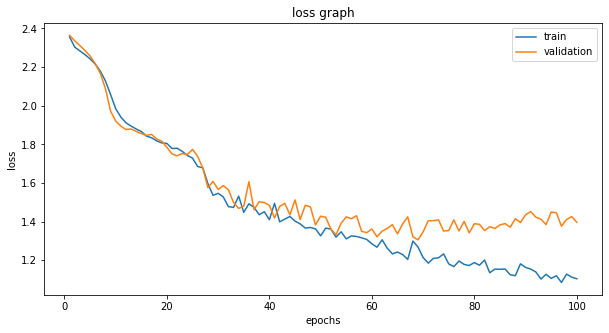

1 tensor(2.3558, grad_fn=<MeanBackward0>)


In [14]:
plt.figure(figsize=(10,5))
plt.plot(range(1,epochs+1), mean_losses_train, label = 'train')
plt.plot(range(1,epochs+1), mean_losses_valid, label = 'validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.title('loss graph')
plt.show()
max_y = max(mean_losses_train)  # Find the maximum y value
max_x = range(1,epochs+1)[mean_losses_train.index(max_y)]  # Find the x value corresponding to the maximum y value
print(max_x, max_y)